# Проект: Обучение с учителем: качество модели

**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.

**Цель исследования** - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Описание данных**

market_file.csv - таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

market_money.csv - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

market_time.csv - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

money.csv - таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

**Этапы проекта:**
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ
4. Объединение таблиц
5. Корреляционный анализ
6. Использоваине пайплайнов
7. Анализ важности признаков
8. Сегментация покупателей
9. Общий вывод

## Загрузка данных

**Импортируем библиотеки**

In [1]:
# !pip install beautifulsoup4==4.9.3
# !pip install matplotlib==3.3.4
# !pip install nltk==3.6.1
# !pip install numpy==1.20.1
# !pip install pandas==1.2.4
# !pip install plotly==5.4.0
# !pip install psycopg2-binary==2.9.2
# !pip install regex==2022.3.15
# !pip install scikit-learn==0.24.1
# !pip install scipy==1.8.0
# !pip install seaborn==0.11.1
# !pip install sqlalchemy==1.4.15
# !pip install statsmodels==0.13.2

In [2]:
#!pip install --upgrade scikit-learn

In [3]:
# Для работы с данными
import pandas as pd
import numpy as np

# Для интерпретации результатов машинного обучения
import shap

# Для корреляционного анализа
import phik

# Построение графиков
import seaborn as sns
import matplotlib.pyplot as plt

# Функция для разделения данных
from sklearn.model_selection import (train_test_split,  # Функция для разделения данных
                                    RandomizedSearchCV) # Импортируем класс RandomizedSearchCV

# Для оценки мультиколлинеарности
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Загружаем нужные классы
# Класс ColumnTransformer помогает работать с данными разного типа в одном наборе
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# дополнительные классы для преобразования данных
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   MinMaxScaler,
                                   RobustScaler)

# Алгоритмы машинного обучения
from sklearn.linear_model import LogisticRegression # Метод бинарной классификации
from sklearn.neighbors import KNeighborsClassifier  # Метод К ближайших соседей
from sklearn.svm import SVC                         # Метод опорных векторов
from sklearn.tree import (DecisionTreeClassifier,   # Модель дерева решения
                         plot_tree)                 # Визуализация модели дерева решения

# Класс для работы с пропусками
from sklearn.impute import SimpleImputer

# Загружаем функцию для работы с метриками
from sklearn.metrics import (roc_auc_score,
                             f1_score)


# Обявляем константы
RANDOM_STATE = 100
TEST_SIZE = 0.25

**Загружаем данные**

In [4]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_money = pd.read_csv('/datasets/market_money.csv')
market_time = pd.read_csv('/datasets/market_time.csv')
money = pd.read_csv('/datasets/money.csv')

**Функция вывода общей информации**

In [5]:
def general_information(data):
    display('Вывод первых строк')
    display(data.head())
    display('Вывод общей информации')
    display(data.info())
    display('Количество пропусков')
    display(data.isna().sum())
    display('Количество дубликатов')
    display(data.duplicated().sum())

### market_file

In [6]:
general_information(market_file)

'Вывод первых строк'

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

'Количество пропусков'

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

'Количество дубликатов'

0

In [7]:
market_file.columns

Index(['id', 'Покупательская активность', 'Тип сервиса', 'Разрешить сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

Переменнуем название столбцов, заменим пробелы на "_". 

Название оставим на кириллице. 

In [8]:
market_file = market_file.rename(
    columns={
        'Покупательская активность':'Покупательская_активность',
        'Тип сервиса':'Тип_сервиса',
        'Разрешить сообщать':'Разрешить_сообщать'
    }
)

market_file.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

### market_money

In [9]:
general_information(market_money)

'Вывод первых строк'

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

'Количество пропусков'

id         0
Период     0
Выручка    0
dtype: int64

'Количество дубликатов'

0

### market_time

In [10]:
general_information(market_time)

'Вывод первых строк'

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

'Количество пропусков'

id        0
Период    0
минут     0
dtype: int64

'Количество дубликатов'

0

Запишем название столбца с заглавной буквы.

In [11]:
market_time = market_time.rename(
    columns={
        'минут':'Минут'
    }
)

market_time.columns

Index(['id', 'Период', 'Минут'], dtype='object')

### money

In [12]:
general_information(money)

'Вывод первых строк'

,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


None

'Количество пропусков'

id;Прибыль    16
dtype: int64

'Количество дубликатов'

1209

Разделим столбцы, в прибыли заменим запятую на точку и приведём тип данных к флоат.

In [13]:
money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
general_information(money)

'Вывод первых строк'

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

'Количество пропусков'

id         0
Прибыль    0
dtype: int64

'Количество дубликатов'

0

### Вывод

В работу поступило 4 датасета
- market_file - 13 столбцов, 1300 строк, 0 пропусков, 0 дубликатов;
- market_money - 3 столбцов, 3900 строк, 0 пропусков, 0 дубликатов;
- market_time - 3 столбцов, 2600 строк, 0 пропусков, 0 дубликатов;
- money - 2 столбцов, 1300 строк, 0 пропусков, 0 дубликатов.

В market_file и market_time отредактированы название столбцов. В money произведено разделение столбцов и проведена замена тип столбца "Прибыль" на float64.

Во всех четырёх датасетах название столбцов соотвествуют описанию. 

Замечены опечатки в названиях данных их редактирование будет произведенно на этапе предобработки данных.

## Предобработка данных

**Функция проверки данных на выбросы.**

In [14]:
def emissions_df(data, column):
    # Описательная статистика
    display(data[column].describe())
    # Диаграмма размаха
    data.boxplot(column=column)
    plt.title('Диаграмма размаха')
    plt.show()

### market_file

Проверим уникальные значения данных.

In [15]:
for i in market_file:
    display(market_file[i].unique())

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['Снизилась', 'Прежний уровень'], dtype=object)

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array([3.4, 4.4, 4.9, 3.2, 5.1, 3.3, 4.7, 4.2, 3.9, 4.6, 4.3, 3.8, 2.7,
       4.8, 2.9, 3. , 2.4, 1.7, 3.6, 4. , 1.5, 3.5, 4.1, 3.1, 1.4, 0.9,
       5.6, 2.6, 5.5, 5.2, 5.8, 5. , 5.4, 5.7, 5.3, 3.7, 6.3, 6.6, 4.5,
       6.1, 5.9])

array([5, 4, 3])

array([ 121,  819,  539,  896, 1064,  762,  431,  284,  192,  154,  450,
        110,  623,  199,  438,  923,  708,  167,  209,  581,  829,  607,
        572,  365,  566,  811,  268,  558,  534,  730,  488,  436,  637,
        554,  330,  504, 1020,  721,  495,  135,  663, 1047,  152,  754,
        525,  169,  966,  645,  706,  689,  882, 1007,  304,  339,  954,
        771,  699,  669,  511,  974,  666,  857, 1048,  756,  506,  759,
        768,  720,  219,  377,  472,  806,  449,  523,  503,  515,  813,
        249,  186,  336,  690,  824,  753,  674,  875,  844,  602,  855,
        448,  344,  922,  298,  893,  881,  372,  788,  937,  764,  851,
       1021,  627,  748,  684,  719,  891,  842,  573, 1057,  342,  638,
        458,  254,  600,  871,  574,  982,  324,  373,  839,  845,  475,
        509,  252,  820,  744,  541, 1079,  900,  474,  957,  773,  717,
        508,  184,  828,  944,  419,  302,  898,  705,  953,  355,  616,
        622,  335, 1025,  755,  549,  308,  903,  6

array([0.  , 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17, 0.13, 0.35, 0.74,
       0.29, 0.98, 0.95, 0.22, 0.4 , 0.24, 0.21, 0.39, 0.9 , 0.89, 0.27,
       0.33, 0.34, 0.32, 0.93, 0.3 , 0.28, 0.31, 0.25, 0.36, 0.16, 0.11,
       0.2 , 0.18, 0.15, 0.6 , 0.12, 0.19, 0.44, 0.47, 0.91])

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

array([6, 4, 5, 3, 2, 1])

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7])

array([1, 2, 6, 3, 7, 9, 4, 5, 8, 0])

array([ 5,  4,  2,  3,  7,  1,  6,  8,  9, 14, 11, 15, 16, 10, 17, 13, 12,
       18, 19, 20])

Название строковых данных пропишем строковыми буквами. Данные "стандартт" заменим на "стандарт".

In [16]:
market_file.columns = market_file.columns.str.lower()
market_file = market_file.applymap(lambda x: x.lower() if isinstance(x, str) else x)
market_file['тип_сервиса'] = market_file['тип_сервиса'].replace('стандартт', 'стандарт')

for i in market_file:
    display(market_file[i].unique())
    
display(market_file.columns)

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['снизилась', 'прежний уровень'], dtype=object)

array(['премиум', 'стандарт'], dtype=object)

array(['да', 'нет'], dtype=object)

array([3.4, 4.4, 4.9, 3.2, 5.1, 3.3, 4.7, 4.2, 3.9, 4.6, 4.3, 3.8, 2.7,
       4.8, 2.9, 3. , 2.4, 1.7, 3.6, 4. , 1.5, 3.5, 4.1, 3.1, 1.4, 0.9,
       5.6, 2.6, 5.5, 5.2, 5.8, 5. , 5.4, 5.7, 5.3, 3.7, 6.3, 6.6, 4.5,
       6.1, 5.9])

array([5, 4, 3])

array([ 121,  819,  539,  896, 1064,  762,  431,  284,  192,  154,  450,
        110,  623,  199,  438,  923,  708,  167,  209,  581,  829,  607,
        572,  365,  566,  811,  268,  558,  534,  730,  488,  436,  637,
        554,  330,  504, 1020,  721,  495,  135,  663, 1047,  152,  754,
        525,  169,  966,  645,  706,  689,  882, 1007,  304,  339,  954,
        771,  699,  669,  511,  974,  666,  857, 1048,  756,  506,  759,
        768,  720,  219,  377,  472,  806,  449,  523,  503,  515,  813,
        249,  186,  336,  690,  824,  753,  674,  875,  844,  602,  855,
        448,  344,  922,  298,  893,  881,  372,  788,  937,  764,  851,
       1021,  627,  748,  684,  719,  891,  842,  573, 1057,  342,  638,
        458,  254,  600,  871,  574,  982,  324,  373,  839,  845,  475,
        509,  252,  820,  744,  541, 1079,  900,  474,  957,  773,  717,
        508,  184,  828,  944,  419,  302,  898,  705,  953,  355,  616,
        622,  335, 1025,  755,  549,  308,  903,  6

array([0.  , 0.75, 0.14, 0.99, 0.94, 0.26, 0.23, 0.17, 0.13, 0.35, 0.74,
       0.29, 0.98, 0.95, 0.22, 0.4 , 0.24, 0.21, 0.39, 0.9 , 0.89, 0.27,
       0.33, 0.34, 0.32, 0.93, 0.3 , 0.28, 0.31, 0.25, 0.36, 0.16, 0.11,
       0.2 , 0.18, 0.15, 0.6 , 0.12, 0.19, 0.44, 0.47, 0.91])

array(['товары для детей', 'домашний текстиль', 'косметика и аксесуары',
       'техника для красоты и здоровья', 'кухонная посуда',
       'мелкая бытовая техника и электроника'], dtype=object)

array([6, 4, 5, 3, 2, 1])

array([ 2,  4,  0,  1,  3,  5,  8,  6,  9, 10,  7])

array([1, 2, 6, 3, 7, 9, 4, 5, 8, 0])

array([ 5,  4,  2,  3,  7,  1,  6,  8,  9, 14, 11, 15, 16, 10, 17, 13, 12,
       18, 19, 20])

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object')

Проверка на выбросы.

In [17]:
market_file.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: маркет_актив_6_мес, dtype: float64

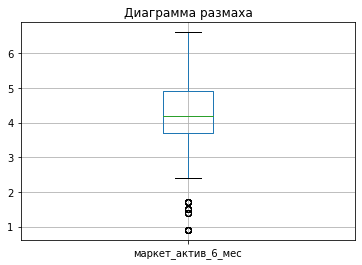

In [18]:
emissions_df(market_file, 'маркет_актив_6_мес')

count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: длительность, dtype: float64

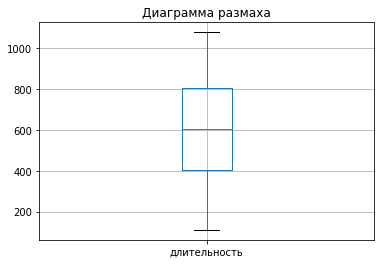

In [19]:
emissions_df(market_file, 'длительность')

count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: акционные_покупки, dtype: float64

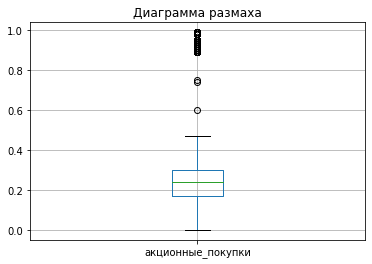

In [20]:
emissions_df(market_file, 'акционные_покупки')

Исправлена опечатка в обозначении данных на "стандарт". В столбце "Длительность" данные без выбросов, в столбцах "Акционные_покупки" и "Маркет_актив_6_мес" имеются выбросы, принято решение их не удалять т.к. их достаточно много их влияние оценим на следующем шаге.

### market_money

Проверим уникальные значения данных.

In [21]:
for i in market_money:
    display(market_money[i].unique())

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

array([   0. , 3293.1, 4472. , ..., 5224.6, 4720. , 4448.3])

Название строковых данных пропишем строковыми символами.

In [22]:
market_money = market_money.applymap(lambda x: x.lower() if isinstance(x, str) else x)
market_money.columns = market_money.columns.str.lower()

for i in market_money:
    display(market_money[i].unique())
    
display(market_money.columns)

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

array([   0. , 3293.1, 4472. , ..., 5224.6, 4720. , 4448.3])

Index(['id', 'период', 'выручка'], dtype='object')

Проверка на выбросы.

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: выручка, dtype: float64

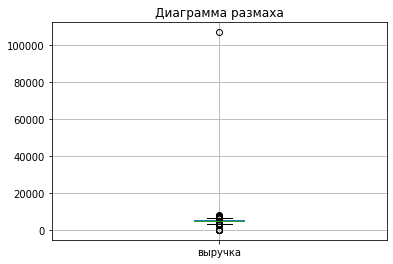

In [23]:
emissions_df(market_money, 'выручка')

Значение выручки в 106862.2 является явным выбросом, удалим его. Т.к. нам в следующем шаге понадобятся только те клиенты которые покупали значение ноль тоже удалим.

count    3893.000000
mean     5007.282918
std       679.724898
min      2758.700000
25%      4592.000000
50%      4959.000000
75%      5363.000000
max      7799.400000
Name: выручка, dtype: float64

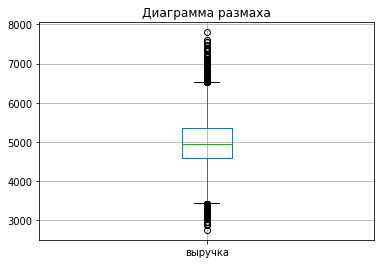

In [24]:
market_money = market_money.loc[market_money['выручка'] != 106862.2]
market_money = market_money.loc[market_money['выручка'] != 0]
# Проверим удаление данных
emissions_df(market_money, 'выручка')

Были удаленны два значения 106862.2 - это явный выброс и 0 - это значение удаленно по условиям исследования. Так же большое колличество выбросов которые не будут удаленны.

### market_time

Название строковых данных пропишем строковыми символами.

In [25]:
market_time = market_time.applymap(lambda x: x.lower() if isinstance(x, str) else x)
market_time.columns = market_time.columns.str.lower()

for i in market_time:
    display(market_time[i].unique())
    
display(market_time.columns)

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

array([14, 13, 10, 12,  8, 11,  6,  7,  9,  5, 15,  4, 16, 17, 19, 18, 22,
       20, 21, 23])

Index(['id', 'период', 'минут'], dtype='object')

Проверим уникальные значения данных.

In [26]:
for i in market_time:
    display(market_time[i].unique())

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

array([14, 13, 10, 12,  8, 11,  6,  7,  9,  5, 15,  4, 16, 17, 19, 18, 22,
       20, 21, 23])

Исправим опечатку в названии данных 'предыдцщий_месяц' на 'предыдущий_месяц' и сделаем их с заглавной буквы.

In [27]:
market_time['период'] = market_time['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time = market_time.applymap(lambda x: x.capitalize() if isinstance(x, str) else x)

Проверка на выбросы.

count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: минут, dtype: float64

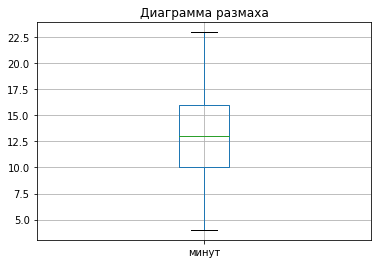

In [28]:
emissions_df(market_time, 'минут')

Исправленна опечатка в данных на 'предыдущий_месяц'. Данные без выбросов.

### money

Название строковых данных пропишем строковыми символами. Проверим уникальные значения данных.

In [29]:
money = money.applymap(lambda x: x.lower() if isinstance(x, str) else x)
money.columns = money.columns.str.lower()

for i in money:
    display(money[i].unique())
    
display(money.columns)

array([215348, 215349, 215350, ..., 216645, 216646, 216647])

array([0.98, 4.16, 3.13, 4.87, 4.21, 3.95, 3.62, 5.26, 4.93, 4.66, 3.06,
       5.08, 4.55, 4.03, 3.49, 1.83, 2.67, 3.65, 2.95, 3.03, 6.27, 3.86,
       2.82, 1.4 , 1.63, 3.69, 4.08, 4.18, 4.26, 4.27, 4.42, 3.88, 2.42,
       4.78, 4.85, 4.05, 3.48, 5.16, 4.6 , 5.7 , 5.44, 4.1 , 2.93, 3.9 ,
       3.28, 5.09, 3.19, 4.77, 5.01, 6.73, 7.43, 4.28, 3.73, 3.38, 3.47,
       5.  , 2.02, 3.68, 2.68, 4.46, 2.41, 5.4 , 3.4 , 4.22, 4.5 , 4.98,
       3.96, 3.18, 4.65, 3.92, 3.89, 5.64, 2.76, 4.25, 3.71, 4.63, 2.97,
       3.24, 3.81, 4.04, 6.33, 4.68, 3.6 , 3.04, 4.41, 3.98, 2.47, 4.52,
       4.01, 5.31, 2.53, 5.83, 4.48, 2.98, 4.92, 3.08, 4.9 , 3.94, 2.99,
       4.62, 3.76, 3.42, 4.17, 4.47, 4.69, 4.59, 2.84, 3.66, 4.97, 2.19,
       2.74, 5.41, 4.12, 3.93, 5.02, 3.52, 3.39, 6.12, 4.64, 3.14, 4.71,
       4.99, 3.74, 4.  , 5.23, 2.08, 6.55, 2.36, 4.32, 3.15, 2.77, 5.56,
       3.44, 3.58, 2.92, 4.67, 3.33, 2.94, 1.06, 2.45, 4.86, 5.05, 3.2 ,
       2.8 , 4.13, 1.81, 2.79, 4.11, 2.55, 3.84, 3.

Index(['id', 'прибыль'], dtype='object')

Проверка на выбросы.

count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: прибыль, dtype: float64

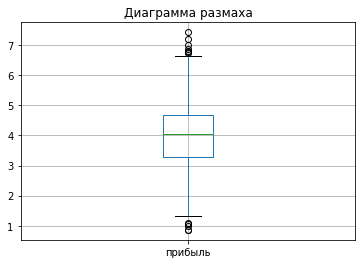

In [30]:
emissions_df(money, 'прибыль')

Значения прибыли имеют выбросы их удалять не будем.

### Вывод

Было выполнено:
- market_file - Исправлена опечатка в обозначении данных на "стандарт". В столбце "Длительность" данные без выбросов, в столбцах "Акционные_покупки" и "Маркет_актив_6_мес" имеются выбросы, принято решение их не удалять т.к. их достаточно много их влияние оценим на следующем шаге.
- market_money - Были удаленны два значения 106862.2 - это явный выброс и 0 - это значение удаленно по условиям исследования. Так же большое колличество выбросов которые не будут удаленны.
- market_time - Исправленна опечатка в данных на 'предыдущий_месяц'. Данные без выбросов.
- money - Значения прибыли имеют выбросы их удалять не будем,
- название столбцов были проведены к змеевидному виду.

## Исследовательский анализ данных

**Функция построения круговой диаграммы для категориальных данных.**

In [31]:
def cat_pie(data, column):
    (
        data[column]
        .value_counts()
        .plot(kind='pie', autopct='%1.0f%%', figsize=(7, 7), label='')
    )
    plt.title(f'Доля клиентов по {column}')
    plt.show()

**Функция построения гистограммы для двух столбцов.**

In [32]:
def num_hist(data, column_1, column_2, bins):
    sns.set()
    plt.figure(figsize=(10, 10))
    if column_2 == None:
        sns.histplot(data, bins=bins, kde=True, x=column_1)
    else:
        sns.histplot(data, bins=bins, kde=True, hue=column_2, x=column_1)
    plt.title(f'Распределение признака {column_1}')
    plt.xlabel(column_1)
    plt.ylabel('Количество')dd
    plt.show()

**Функция построения гистограммы для категориальных переменных.**

In [33]:
def count_hist(data, column_1, column_2):
    sns.set()
    plt.figure(figsize=(15, 10))
    sns.countplot(data=data, x=column_1, hue=column_2) 
    plt.title(f'Распределение признака {column_1}')
    plt.xlabel(column_1)
    plt.ylabel('Количество')
    plt.show()

### market_file

Строим круговые диаграммы для категориальных данных.

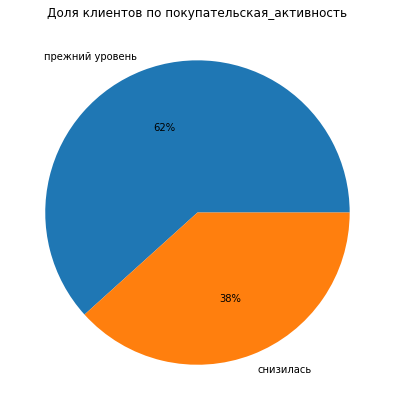

In [34]:
cat_pie(market_file, 'покупательская_активность')

Большинство клиентов, 62%, сохранило свою активность. У 38% клиентов активность снизилась, это довольно весомая часть клиентов.

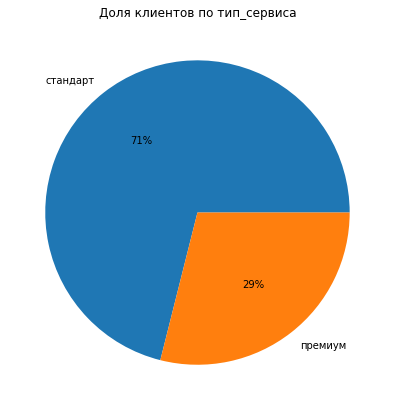

In [35]:
cat_pie(market_file, 'тип_сервиса')

Количество клиентов с премиумным сервисом 29%.

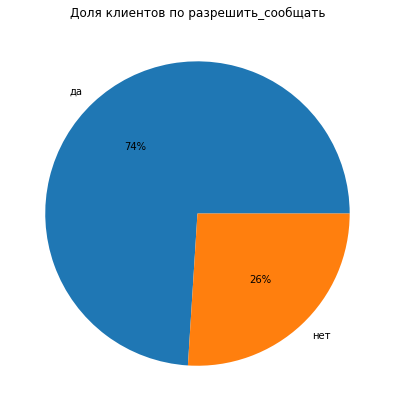

In [36]:
cat_pie(market_file, 'разрешить_сообщать')

Большинство клиентов, 74%, хотят получать дополнительные предложения о товарах.

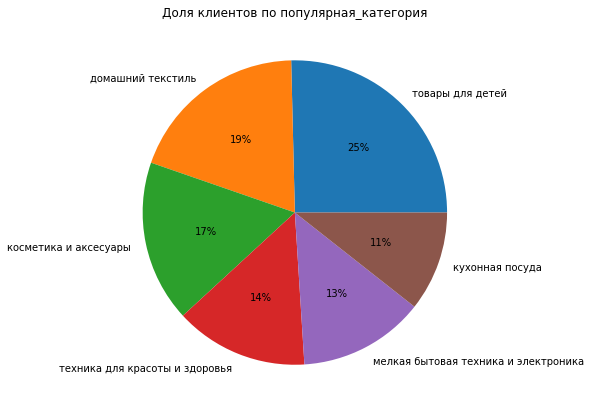

In [37]:
cat_pie(market_file, 'популярная_категория')

Четверть всех покупок занимает товары для детей, какую то категорию выделить невозможно.

Построение диаграммы.

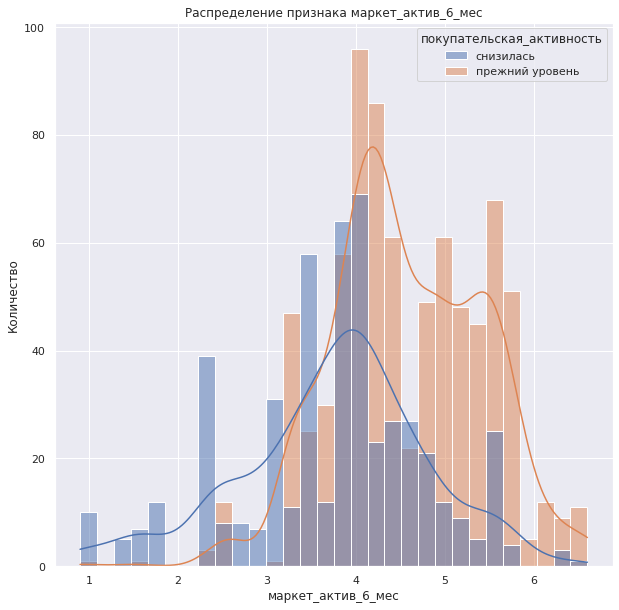

In [38]:
num_hist(market_file, 'маркет_актив_6_мес', 'покупательская_активность', 30)

Маркетинговая активность для клиентов со сниженной покупательской активностью распределенны болле менне на одном уровне в течении всех 6 месяцев, со сплеском в период с 3 по 4 месяц.

Маркетинговая активность для клиентов с прежним уровнем покупательской активностью показали свою активность с 3 по 6 месяц, с 1 по 3 месяц таких клиентов практически нет.

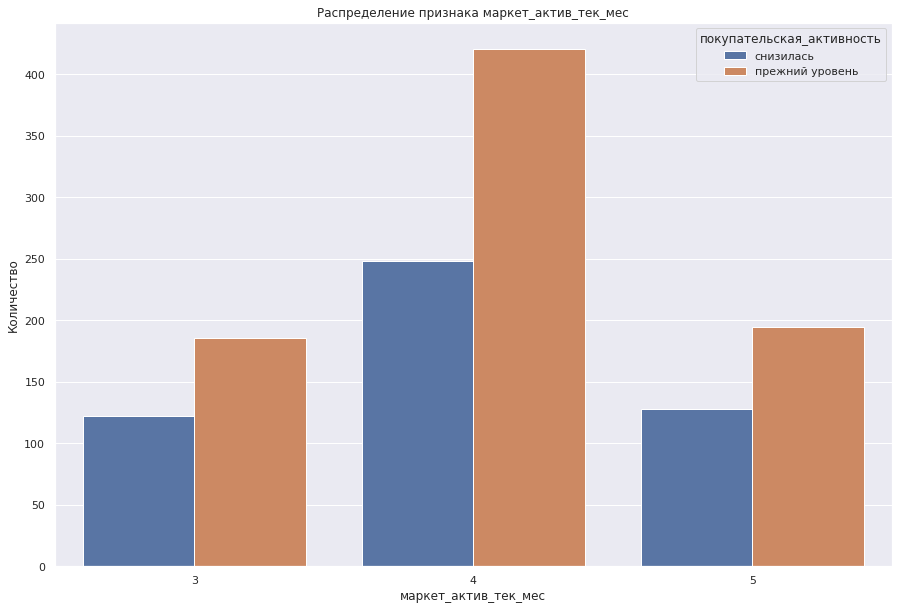

In [39]:
count_hist(market_file, 'маркет_актив_тек_мес', 'покупательская_активность')

Больше всех рекламу получают клиенты с прежней покупательской активностью.

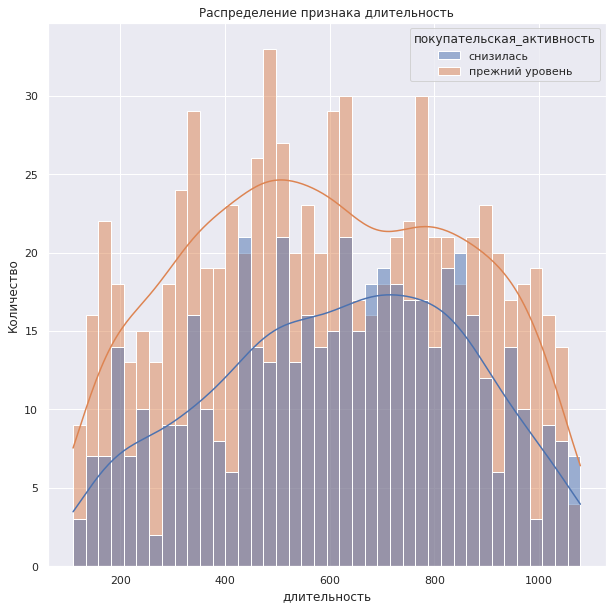

In [40]:
num_hist(market_file, 'длительность', 'покупательская_активность', 40)

Имеются выбросы по двум категориям, скорее всего, они указывают на регистрацию клиентов в момент каких либо акций или проведении рекламной компании интернет магазина.

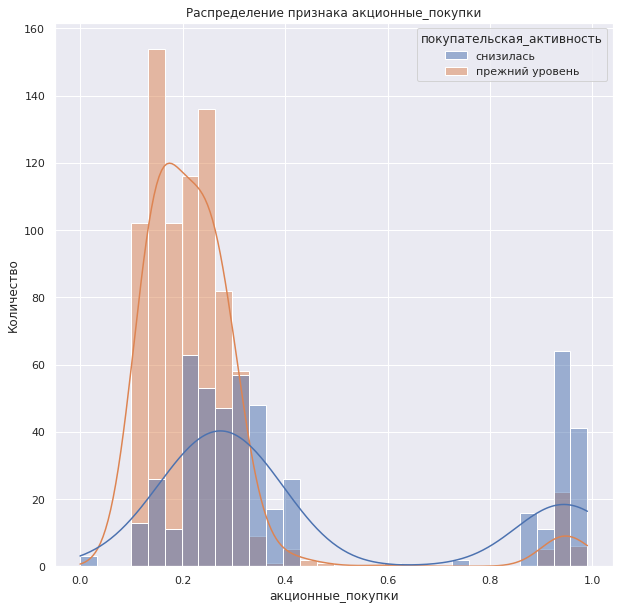

In [41]:
num_hist(market_file, 'акционные_покупки', 'покупательская_активность', 30)

Клиенты со сниженной покупательской активностью чаще покупают товары по акции.

In [42]:
market_file['средний_просмотр_категорий_за_визит'].unique()

array([6, 4, 5, 3, 2, 1])

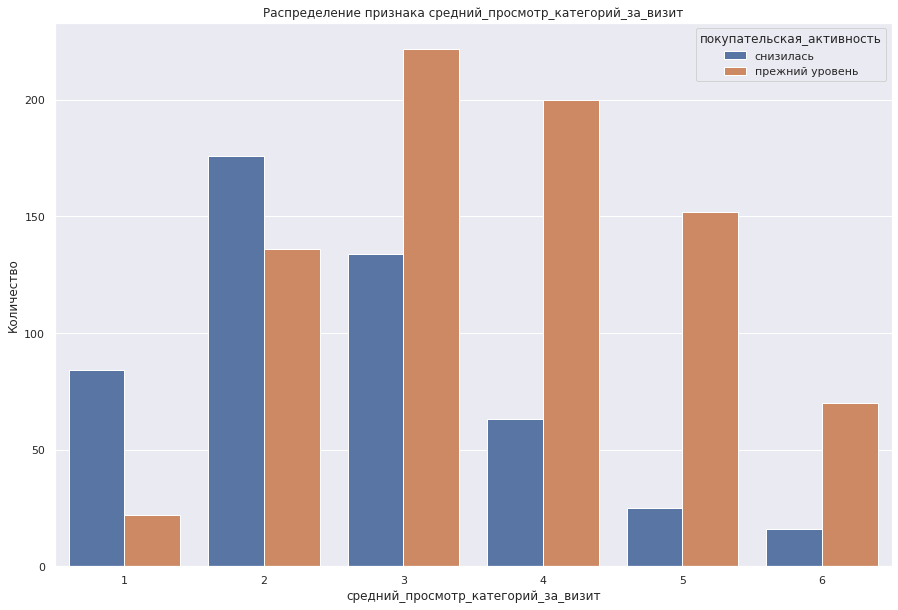

In [43]:
count_hist(market_file, 'средний_просмотр_категорий_за_визит', 'покупательская_активность')

Клиенты с прежней покупательской способностью просматривают сразу несколько категорий товаров. А те у кого снизилась покупательская способность смотрят в основном до 3 категорий, что указывает на просмотр конкретных товаров, скорее всего по акции.

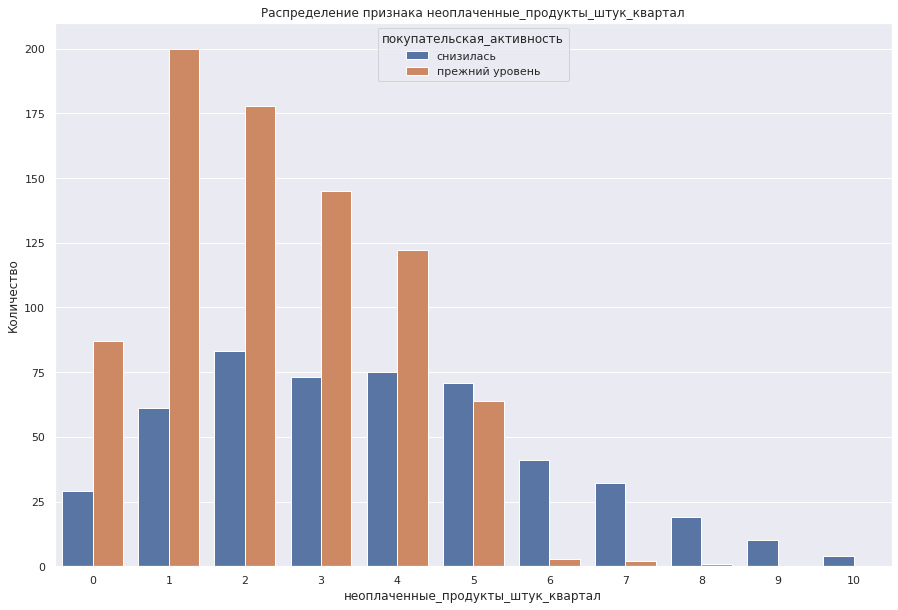

In [44]:
count_hist(market_file, 'неоплаченные_продукты_штук_квартал', 'покупательская_активность')

Количество неоплаченных товаров уменьшается с их количеством, что указывает, скорее всего, на то, что клиенты набирают корзину и только когда наберётся 6 и более товаров оплачивают и забирают их.

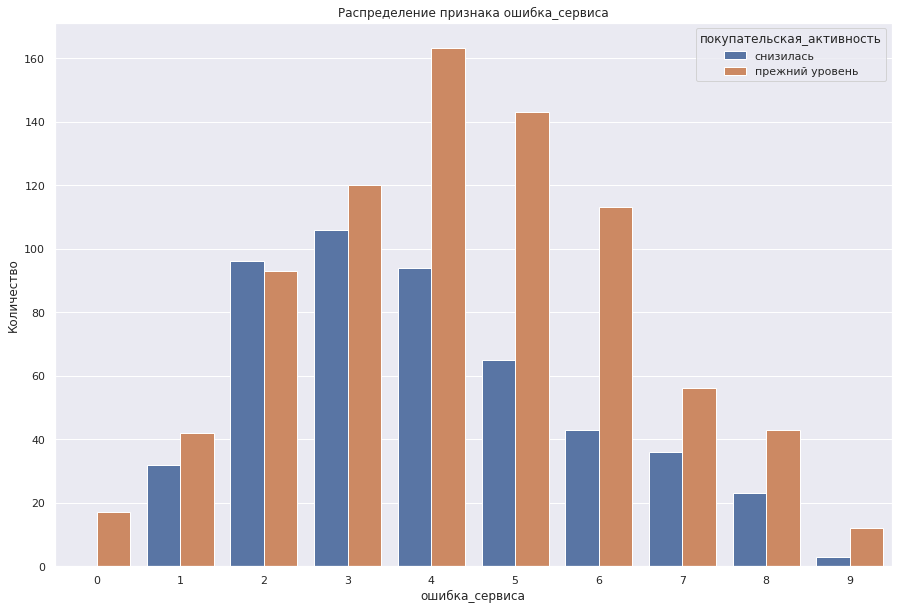

In [45]:
count_hist(market_file, 'ошибка_сервиса', 'покупательская_активность')

У большинства клиентов количество ошибок от трёх до шести.

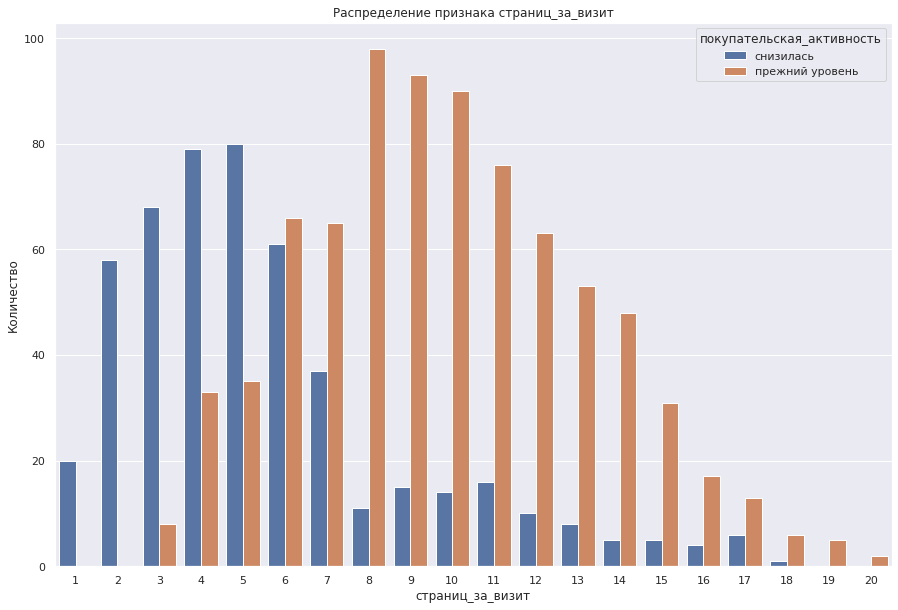

In [46]:
count_hist(market_file, 'страниц_за_визит', 'покупательская_активность')

Таже картина, что просмотр категорий за визит.

### market_money

Строим круговые диаграммы для категориальных данных.

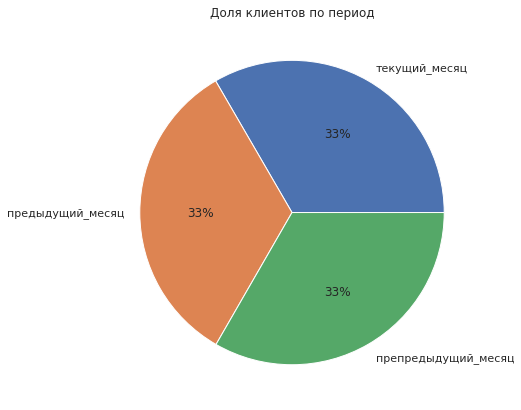

In [47]:
cat_pie(market_money, 'период')

Подсчитаем выручку за каждый из трёх месяцев.

In [48]:
market_money_period = (
    market_money
    .pivot_table(index='период', values='выручка', aggfunc='sum')
    .sort_values(by='выручка', ascending=False)
)
market_money_period

,выручка
период,
текущий_месяц,6802586.9
предыдущий_месяц,6417996.5
препредыдущий_месяц,6272769.0


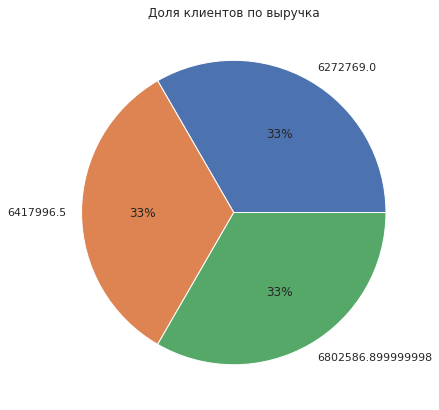

In [49]:
cat_pie(market_money_period, 'выручка')

Построение диаграммы.

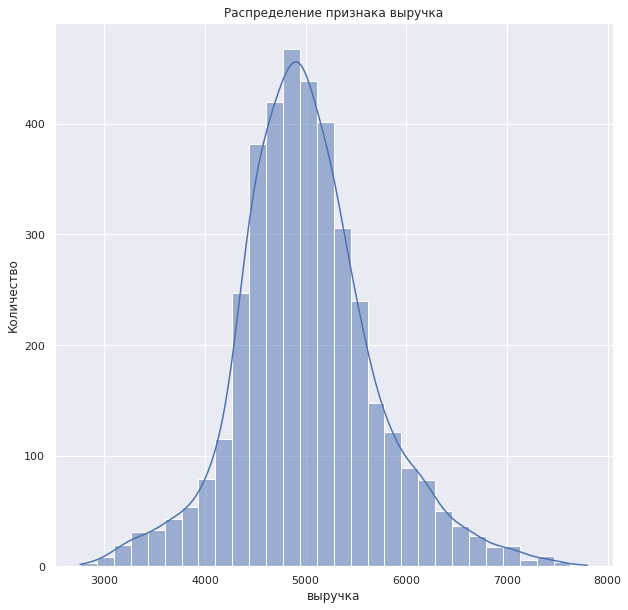

In [50]:
num_hist(market_money, 'выручка', None, 30)

Выручка магазина растёт от в течении последних трёх месяцев.

Диаграмма выручки выглядит нормально.

### market_time

Строим круговые диаграммы для категориальных данных.

Подсчитаем количество минут по каждому месяцу.

In [51]:
market_time_period = (
    market_time
    .pivot_table(index='период', values='минут', aggfunc='sum')
    .sort_values(by='минут', ascending=False)
)
market_time_period

,минут
период,
Предыдущий_месяц,17508
Текущий_месяц,17166


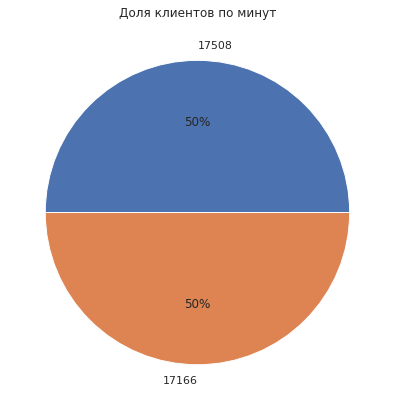

In [52]:
cat_pie(market_time_period, 'минут')

Построение диаграммы.

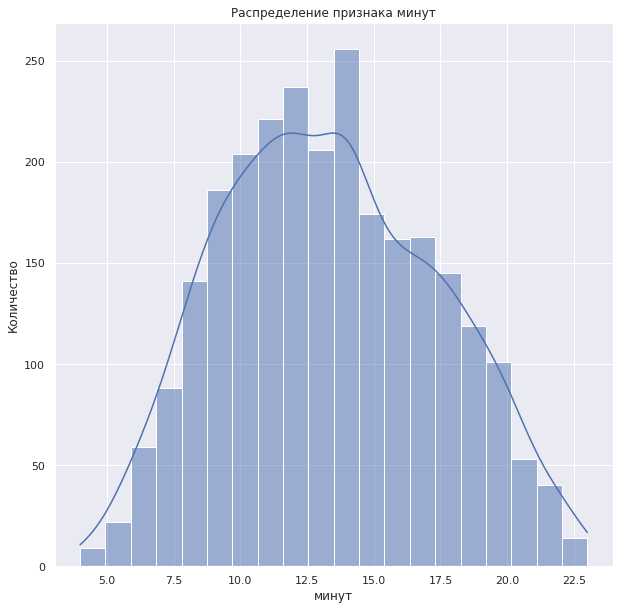

In [53]:
num_hist(market_time, 'минут', None, 20)

Клиенты провели времени, примерно, одинаково в двух последних месяцах.

### money

Построение диаграммы.

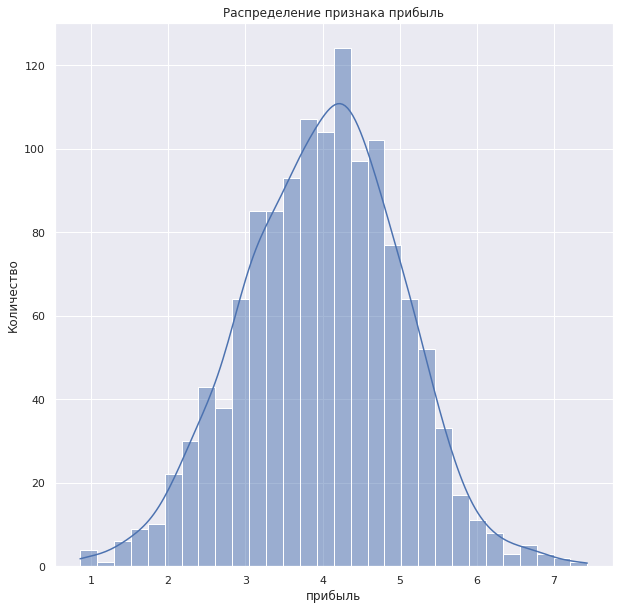

In [54]:
num_hist(money, 'прибыль', None, 30)

Значения признака прибыль распределены нормально.

### Выделяем клиентов с покупательской способностью не менее трёх мясецев.

In [55]:
# Группируем клиентов по id
# Применяем агрегатную функцию count по группе 'Период'
month_3 = market_money.groupby('id').agg({'период': 'count'})

# Оставляем клиентов которые активны все 3 месяца
month_3 = month_3.loc[month_3['период'] == 3]

# Применяем фильтр данных isin к market_file по значением из month_3
market_file = market_file[market_file['id'].isin(month_3.index)]

display(f'Количество клиентов, чья активность 3 и более месяцев {len(market_file)}')

'Количество клиентов, чья активность 3 и более месяцев 1296'

### Вывод

Обобщая информацию по всем 4 датафреймам можно увидеть, что даже при снижении маркетинговой активности время пользователей в магазине не изменилось, выручка при этом расла последнии 3 месяца. 

Пользователи со сниженной покупательской активностью просматривают страниц и категорий товаров одинаково, что даёт нам понять, что они ищут товары только по акции. Они же получают всех больше рекламных уведомлений от магазина.

Пользователи с прежней активностью просматривают большое количество страниц в магазине и различные категории, и отправляют товары в корзину и оплачивают их когда в корзине становится 6 и более товаров.

По итогу 1296 клиентов сохраняло свою активность на протяжении не менее трёх месяцев.

## Объединение таблиц

In [56]:
# Создаём сводную таблицу
market_money_group = market_money.pivot_table(index='id', columns='период')
# Переименовываем столбцы
market_money_group.columns = ['выручка_предыдущий_месяц',
                              'выручка_препредыдущий_месяц',
                              'выручка_текущий_месяц']
# Создаём столбец id 
#market_money_group['id'] = market_money_group.index

# Создаём сводную таблицу
market_time_group = market_time.pivot_table(index='id', columns='период')
# Переименовываем столбцы
market_time_group.columns = ['минут_предыдущий_месяц',
                             'минут_текущий_месяц']

# Создаём итоговый датафрейм объединяя market_file и market_money_group
market_result = market_file.join(market_money_group, on='id')

# Объединяем датафреймы market_result и market_time_group
market_result = market_result.join(market_time_group, on='id')

# Выводим общую информацию
general_information(market_result)

'Вывод первых строк'

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   object 
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   акционные_покупки                    1296 non-null   float64
 8   популярная_категория                 1296 non-null   object 
 9   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 11  ошибка_сервиса                

None

'Количество пропусков'

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
dtype: int64

'Количество дубликатов'

0

### Вывод

Итоговая таблица market_result состоящая из market_file, market_money, market_time:
- 18 столбцов,
- 1296 записей,
- пропуски отсуствуют,
- дубликаты отсуствуют.

## Корреляционный анализ

In [57]:
# Создаём переменную для корреляционного анализа
# Удаляем столбец c id, т.к. он ни на, что не влияет
# Строим матрицу корреляции для числовых столбцов
quantity_phik = (
    market_result
    .drop('id', axis=1)
    .phik_matrix(interval_cols=['маркет_актив_6_мес',
                               'маркет_актив_тек_мес',
                               'длительность',
                               'акционные_покупки',
                               'средний_просмотр_категорий_за_визит',
                               'неоплаченные_продукты_штук_квартал',
                               'ошибка_сервиса',
                               'страниц_за_визит',
                               'выручка_предыдущий_месяц',
                               'выручка_препредыдущий_месяц',
                               'выручка_текущий_месяц',
                               'минут_предыдущий_месяц',
                               'минут_текущий_месяц'])
)

# Выводим корреляционную матрицу
(
    quantity_phik
    .style.background_gradient(cmap='RdYlGn', axis=0)
)

,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц
покупательская_активность,1.000000,0.129940,0.000000,0.544831,0.000000,0.099901,0.506276,0.299717,0.539607,0.505655,0.224154,0.749888,0.224638,0.497393,0.197213,0.685138,0.576770
тип_сервиса,0.129940,1.000000,0.289965,0.089911,0.045258,0.401411,0.030010,0.070809,0.185391,0.120027,0.079515,0.102594,0.000000,0.069704,0.124216,0.131814,0.000000
разрешить_сообщать,0.000000,0.289965,1.000000,0.000000,0.052618,0.253831,0.012198,0.073684,0.070359,0.195982,0.021839,0.042134,0.080842,0.000000,0.060907,0.038387,0.000000
маркет_актив_6_мес,0.544831,0.089911,0.000000,1.000000,0.079854,0.000000,0.279553,0.150386,0.206788,0.289421,0.142401,0.396769,0.155476,0.315331,0.039795,0.363950,0.330601
маркет_актив_тек_мес,0.000000,0.045258,0.052618,0.079854,1.000000,0.174233,0.000000,0.136243,0.246633,0.144203,0.116946,0.000000,0.051824,0.000000,0.000000,0.107945,0.061410
длительность,0.099901,0.401411,0.253831,0.000000,0.174233,1.000000,0.000000,0.000000,0.186795,0.192611,0.175608,0.122495,0.125572,0.113200,0.147048,0.026448,0.101481
акционные_покупки,0.506276,0.030010,0.012198,0.279553,0.000000,0.000000,1.000000,0.122385,0.199180,0.237962,0.000000,0.311418,0.060733,0.226381,0.071094,0.262324,0.250558
популярная_категория,0.299717,0.070809,0.073684,0.150386,0.136243,0.000000,0.122385,1.000000,0.226116,0.248620,0.000000,0.160300,0.252097,0.043528,0.237240,0.195233,0.089883
средний_просмотр_категорий_за_визит,0.539607,0.185391,0.070359,0.206788,0.246633,0.186795,0.199180,0.226116,1.000000,0.325578,0.070315,0.262271,0.098440,0.176828,0.092597,0.159837,0.182568
неоплаченные_продукты_штук_квартал,0.505655,0.120027,0.195982,0.289421,0.144203,0.192611,0.237962,0.248620,0.325578,1.000000,0.032907,0.363760,0.249171,0.261016,0.230022,0.256632,0.232383


Проведём оценку на мультиколлинеарность, будем использовать Коэффициент инфляции дисперсии или VIF — это мера, которая помогает обнаружить степень мультиколлинеарности в множественной регрессионной модели. Он показывает, насколько увеличивается дисперсия коэффициента оценки из-за линейной зависимости с другими предикторами.

In [58]:
# Прописываем числовые столбцы
X_num = ['маркет_актив_6_мес',
     'маркет_актив_тек_мес',
     'длительность',
     'акционные_покупки',
     'средний_просмотр_категорий_за_визит',
     'неоплаченные_продукты_штук_квартал',
     'ошибка_сервиса',
     'страниц_за_визит',
     'выручка_предыдущий_месяц',
     'выручка_препредыдущий_месяц',
     'выручка_текущий_месяц',
     'минут_предыдущий_месяц',
     'минут_текущий_месяц']

# Таблица только с числовыми столбцами
X = market_result[X_num]

# Добавляем константу
X = add_constant(X)

# Расчёт VIF для каждого предиктора
vifs = pd.DataFrame()
vifs['variable'] = X.columns
vifs['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vifs

,variable,vif
0,const,352.524089
1,маркет_актив_6_мес,1.220849
2,маркет_актив_тек_мес,1.044578
3,длительность,1.099452
4,акционные_покупки,1.185679
5,средний_просмотр_категорий_за_визит,1.178602
6,неоплаченные_продукты_штук_квартал,1.198629
7,ошибка_сервиса,1.079350
8,страниц_за_визит,1.418264
9,выручка_предыдущий_месяц,4.263015


Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

### Вывод

О мультиколлинеарности можно говорить если значение корреляции выше 0.9. Такой корреляции для целевого признака, покупательская активность, нет.

Проведён дополнительный анализ по VIF метрике. По её условиям о мультиколлинеарности можно говорить при значении метрики выше 5, не один параметр не отвечает данному условию.

Поэтому можно сделать вывод об отсуствии мультиколлиарности.

## Использование пайплайнов

Подготовка данных:
- Покупательская_активность - целевой признак, закодируем его значениями 0 и 1,
- Акционные_покупки - закодируем в категориальный признак.

In [59]:
market_result['покупательская_активность'] = (
    market_result['покупательская_активность']
    .apply(lambda x: 0 if x=='прежний уровень' else 1)
    .astype(int)
)

market_result['категория_акционных_покупок'] = (
    market_result['акционные_покупки']
    .apply(lambda x: 'часто покупает по акции' if x>=0.5 else 'редко покупает по акции')
)
market_result = market_result.drop('акционные_покупки', axis=1)

# Проверим итоговую таблицу после преобразования
general_information(market_result)

'Вывод первых строк'

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,категория_акционных_покупок
1,215349,1,премиум,да,4.4,4,819,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,часто покупает по акции
2,215350,1,стандарт,нет,4.9,3,539,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,редко покупает по акции
3,215351,1,стандарт,да,3.2,5,896,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,часто покупает по акции
4,215352,1,стандарт,нет,5.1,3,1064,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,часто покупает по акции
5,215353,1,стандарт,да,3.3,4,762,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,редко покупает по акции


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   покупательская_активность            1296 non-null   int64  
 2   тип_сервиса                          1296 non-null   object 
 3   разрешить_сообщать                   1296 non-null   object 
 4   маркет_актив_6_мес                   1296 non-null   float64
 5   маркет_актив_тек_мес                 1296 non-null   int64  
 6   длительность                         1296 non-null   int64  
 7   популярная_категория                 1296 non-null   object 
 8   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 10  ошибка_сервиса                       1296 non-null   int64  
 11  страниц_за_визит              

None

'Количество пропусков'

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
категория_акционных_покупок            0
dtype: int64

'Количество дубликатов'

0

In [60]:
market_result_copy = market_result.copy()

# Сохраняем выборки
X = market_result.drop(['покупательская_активность', 'id'], axis=1)
y = market_result['покупательская_активность']

# Разделение данных на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

# Вводим обозначения для типов исходных данных
# Нужно кодировать с помощью OneHotEncoder
ohe_columns = ['тип_сервиса',
               'разрешить_сообщать',
               'популярная_категория']

#  Нужно кодировать с помощью OrdinalEncoder
ord_columns = ['категория_акционных_покупок']

# Количественные признаки необходимо масштабировать
num_columns = ['маркет_актив_6_мес',
               'маркет_актив_тек_мес',
               'длительность',
               'средний_просмотр_категорий_за_визит',
               'неоплаченные_продукты_штук_квартал',
               'ошибка_сервиса',
               'страниц_за_визит',
               'выручка_предыдущий_месяц',
               'выручка_препредыдущий_месяц',
               'выручка_текущий_месяц',
               'минут_предыдущий_месяц',
               'минут_текущий_месяц']

In [61]:
# Добавляем ОНЕ-кодирование в паплайн
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    ),
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='error')
        )
    ]
)

In [62]:
# Добавляем Ordinal-кодирование в пайплайн
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['часто покупает по акции', 'редко покупает по акции']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [63]:
# Код для паплайна подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [64]:
# Итоговый паплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Для модели SVC было выбрано ядро linear, а не poly т.к. затрачивалось очень много времени для выполнения кода. 

In [65]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 10),
        'models__min_samples_split': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear')],
        'models__degree': range(2, 10),
        'models__C': np.logspace(-2, 2, 10),
        'models__gamma': ['scale', 'auto'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [66]:
# Поиск лучшего решения 
# методом случайного поиска перебором гиперпараметров и методов подготовки данных
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1    
)

# Обучаем
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['тип_сервиса',
                                                                                'разрешить_сообщать',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_befor...
                                                        random_state=100)],
                                         'models__C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02]),
                                         'models__degree': range(2, 10),
                                         'models__gamma': ['scale', 'auto'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=100, scoring='roc_auc')

In [67]:
display(f'Лучшая модель и её параметры: {randomized_search.best_estimator_}')
display(f'Метрика по кросс валидационной выборке: {randomized_search.best_score_}')

"Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',\n                 ColumnTransformer(remainder='passthrough',\n                                   transformers=[('ohe',\n                                                  Pipeline(steps=[('simpleImputer_ohe',\n                                                                   SimpleImputer(strategy='most_frequent')),\n                                                                  ('ohe',\n                                                                   OneHotEncoder(drop='first'))]),\n                                                  ['тип_сервиса',\n                                                   'разрешить_сообщать',\n                                                   'популярная_категория']),\n                                                 ('ord',\n                                                  Pipeline(steps=[('simpleImputer_before_ord',\n                                                                   Si

'Метрика по кросс валидационной выборке: 0.8971031246122155'

In [68]:
# Подготовка данных
y_test_pred = randomized_search.predict(X_test)

# decision_function т.к. модель SVC
y_test_proba = randomized_search.decision_function(X_test)

display(f'Метрика ROC-AUC на тестовых данных:{roc_auc_score(y_test, y_test_proba)}')
display(f'Метрика F1 на тестовых данных:{f1_score(y_test, y_test_pred, average="macro")}')

'Метрика ROC-AUC на тестовых данных:0.9059580148040287'

'Метрика F1 на тестовых данных:0.8786769294778448'

### Вывод

Способ для поиска модели и гиперпараметров был выбран RandomizedSearchCV потому, что перед нами стоит задача найти лучшую модель идля экономии времени был выбран этот способ при следующих параметрах:
- cv=5 стандарное количество раз тестирования модели,
- scoring - стратегия оценки производительности модели была выбрана 'roc_auc' т.к. эта метрика работает при оценки сразу 4 моделей и отсуствует необходимость выберать определённые пороги отсечения и учитывает возможность дисбаланса классов.

В результате работы поплайна были обработаны 4 модели:  KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Лучшей стала с гиперпараметрами SVC:
- С - параметр регуляризации = 1.668,
- kernel - ядро полиномиальное,
- degree - степень полимиального ядра = 2,
- random_state=100)

Метрики:
- метрика по кросс валидационной выборке: 0.897
- ROC-AUC на тестовых данных: 0.906 
- F1 на тестовых данных: 0.879

Модель выдаёт довольно хорошие метрики, что даёт нам уверенность в её работоспособности.

## Анализ важности признаков

**Подготовка данных**

In [69]:
randomized_search.best_estimator_.named_steps['models']

SVC(C=1.6681005372000592, degree=2, kernel='linear', random_state=100)

In [70]:
# Обучаем и преобразуем тренировочные данные
X_train_2 = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
# Преобразуем тестовые данные
X_test_2 = pipe_final.named_steps['preprocessor'].transform(X_test)
# Выделяем имена столбцов
feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
# Создаём датафрейм с тестовыми даннами
X_test_2 = pd.DataFrame(X_test_2, columns=feature_names)

# Инициализируем SHAP
explainer = shap.LinearExplainer(randomized_search
                                 .best_estimator_
                                 .named_steps['models']
                                 , X_train_2)
shap_values = explainer.shap_values(X_test_2)

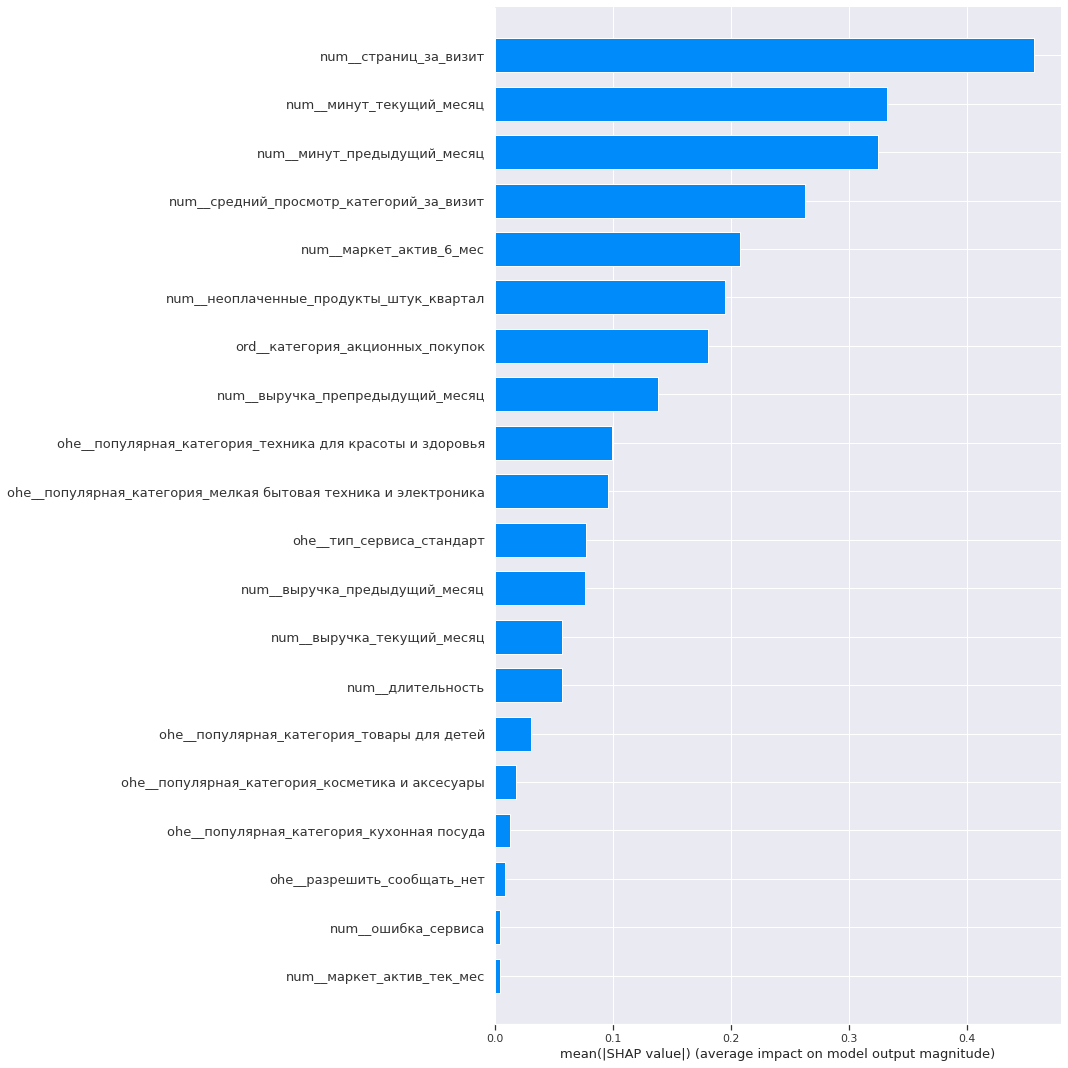

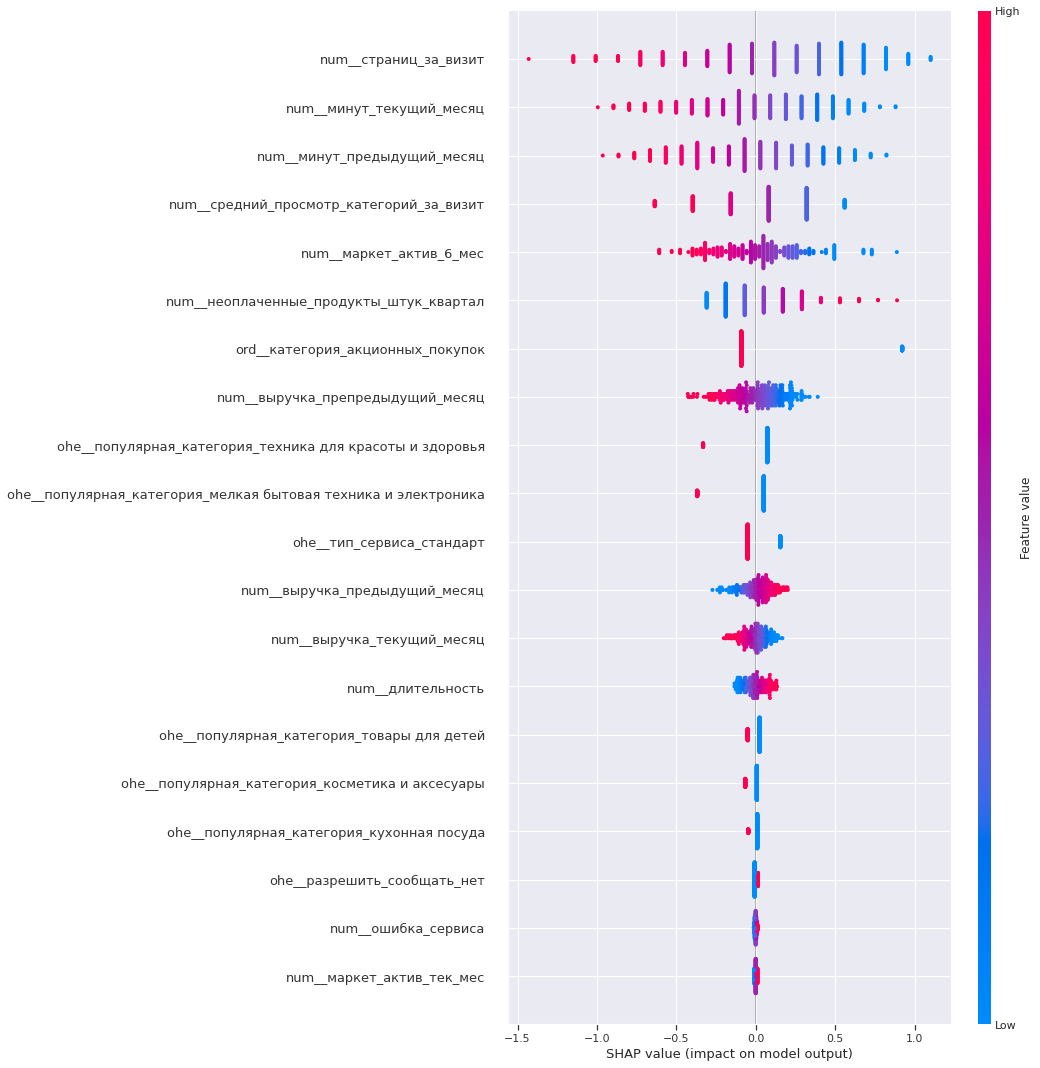

In [71]:
shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="bar", 
    max_display=30, 
    plot_size=(15, 15) 
)

shap.summary_plot(
    shap_values, 
    X_test_2, 
    plot_type="dot", 
    max_display=30, 
    plot_size=(15, 15)  
)

plt.show()

In [72]:
market_result.columns

Index(['id', 'покупательская_активность', 'тип_сервиса', 'разрешить_сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'популярная_категория', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
       'минут_предыдущий_месяц', 'минут_текущий_месяц',
       'категория_акционных_покупок'],
      dtype='object')

### Вывод

Для модели важны признаки (интрепритация по beeswarm):
- Самыми важными признаками для сохранения покупательской активности просмотр страниц_за_визит, минут_текущий_месяц, минут_предыдущий_месяц, средний_просмотр_категорий_за_визит, маркет_актив_6_мес;
- Признаки неоплаченные_продукты_штук_квартал, разрешить_сообщать_нет, ошибка_сервиса, маркет_актив_тек_мес отрицательно влияют на сохранение покупательской активности, но их значение настолько невелико, что можно предположить, что нам необходимо искать другую причину влияющую на снижение покупательской активности.

## Сегментация покупателей

In [73]:
# Сохраняем выборки
X_copy = market_result_copy.drop('покупательская_активность', axis=1)
y_copy = market_result_copy['покупательская_активность']

# Разделение данных на тренировочную и тестовую выборку
X_train_copy, X_test_copy, y_train_copy, y_test_copy = train_test_split(
    X_copy,
    y_copy,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y_copy
)

In [74]:
# Копируем данные
X_train_result = X_train_copy.copy()
X_test_result = X_test_copy.copy()

# Расчитываем вероятность
X_train_result['вероятность_снижения']  = randomized_search.decision_function(X_train_copy)
X_test_result['вероятность_снижения']  = randomized_search.decision_function(X_test_copy)

# Соединяем таблицу и значения 'Вероятность_снижения'
market_result_copy = pd.concat([X_train_result, X_test_result])

# display(X_train_result.head())
# display(market_result.head())
# display(money.info())
# display(market_result.info())


# Объединение итоговой таблицы с money
money = money.set_index('id')
market_result_copy = market_result_copy.join(money, on='id')

# # Выводим общую информацию
general_information(market_result_copy)

'Вывод первых строк'

,id,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,категория_акционных_покупок,вероятность_снижения,прибыль
966,216314,премиум,да,5.5,5,269,товары для детей,2,4,1,17,5324.0,5493.0,5600.9,10,8,редко покупает по акции,-1.163923,4.62
1190,216538,премиум,да,4.9,4,482,косметика и аксесуары,3,2,2,12,4969.0,4624.0,5398.0,9,16,редко покупает по акции,-0.980593,2.81
200,215548,стандарт,да,3.5,4,903,кухонная посуда,3,1,3,4,5324.5,4228.0,5761.3,11,12,редко покупает по акции,0.751647,3.84
1239,216587,стандарт,да,4.4,3,286,товары для детей,4,0,7,14,5265.5,4895.0,5716.6,10,17,редко покупает по акции,-2.198358,2.00
512,215860,стандарт,да,5.5,5,242,кухонная посуда,5,4,4,11,4204.5,4614.0,3979.6,18,19,редко покупает по акции,-2.643941,5.34


'Вывод общей информации'

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 966 to 503
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1296 non-null   int64  
 1   тип_сервиса                          1296 non-null   object 
 2   разрешить_сообщать                   1296 non-null   object 
 3   маркет_актив_6_мес                   1296 non-null   float64
 4   маркет_актив_тек_мес                 1296 non-null   int64  
 5   длительность                         1296 non-null   int64  
 6   популярная_категория                 1296 non-null   object 
 7   средний_просмотр_категорий_за_визит  1296 non-null   int64  
 8   неоплаченные_продукты_штук_квартал   1296 non-null   int64  
 9   ошибка_сервиса                       1296 non-null   int64  
 10  страниц_за_визит                     1296 non-null   int64  
 11  выручка_предыдущий_месяц     

None

'Количество пропусков'

id                                     0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_предыдущий_месяц               0
выручка_препредыдущий_месяц            0
выручка_текущий_месяц                  0
минут_предыдущий_месяц                 0
минут_текущий_месяц                    0
категория_акционных_покупок            0
вероятность_снижения                   0
прибыль                                0
dtype: int64

'Количество дубликатов'

0

Построим общую диаграмму рассеивания

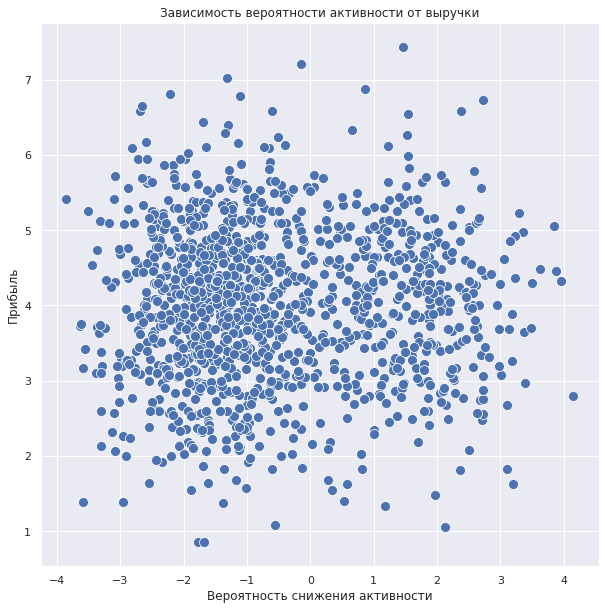

In [75]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=market_result_copy,
                x='вероятность_снижения',
                y='прибыль',
                s=100)
plt.title('Зависимость вероятности активности от выручки')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Прибыль')
plt.show()

Основная плотность находится в квадрате 'Вероятность снижения активности' от -3 до -1 и Прибыль от 3 до 5. Клиенты которые стараются сохранить активность приносят больше прибыли, что очевидно.

**Функция диаграммы рассеяния прибыли и вероятности снижения активности в зависимости от категориальных признаков**

In [76]:
def market_scat(cat_columns):
    for i in cat_columns:
        plt.figure(figsize=(10, 10))
        sns.scatterplot(data=market_result_copy,
                        x='вероятность_снижения',
                        y='прибыль',
                        s=100,
                        hue=i,
                        style=i)
        plt.title('Зависимость вероятности снижения активности от выручки')
        plt.xlabel('Вероятность снижения активности')
        plt.ylabel('Прибыль')
        plt.show()

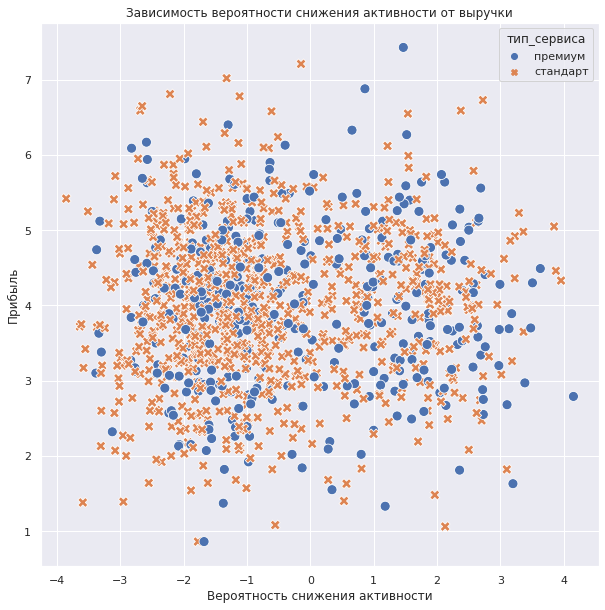

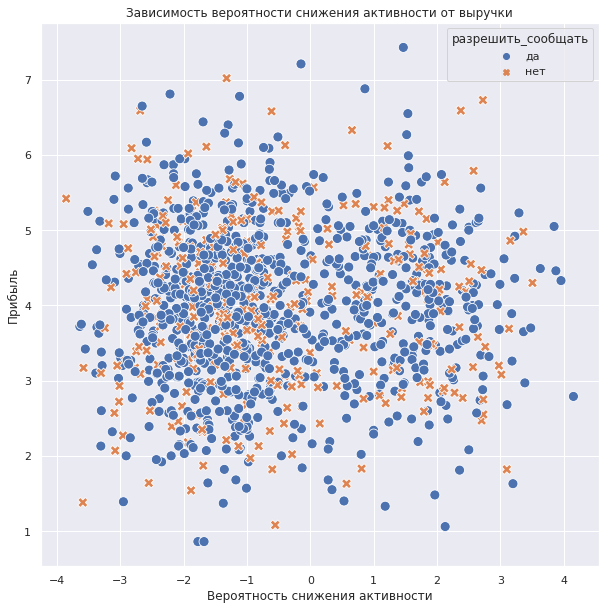

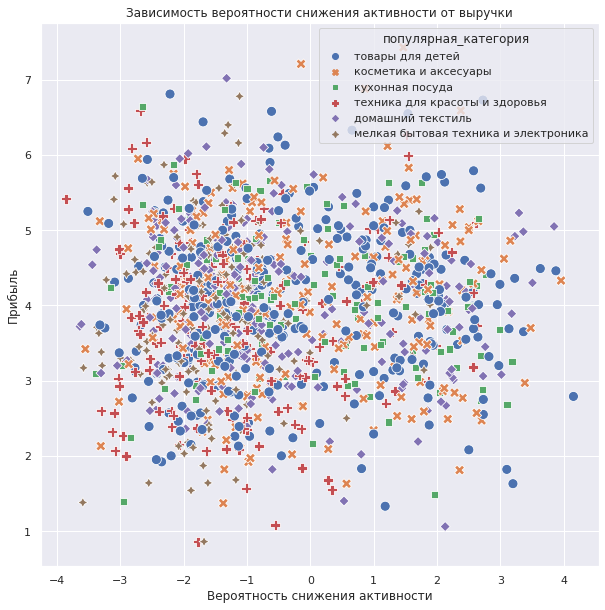

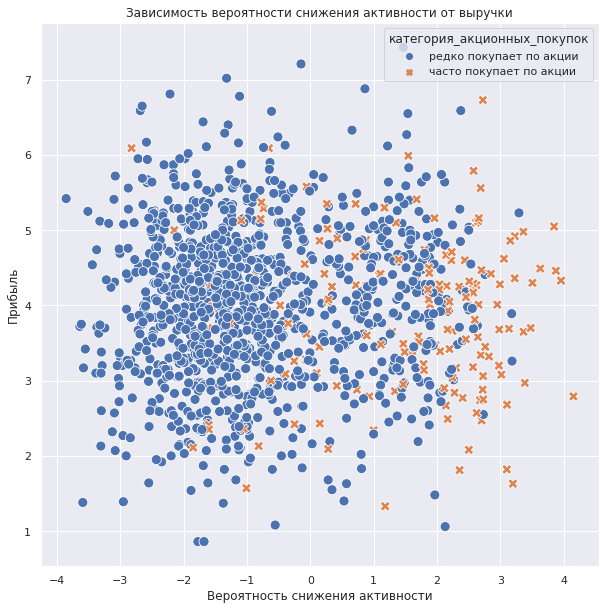

In [77]:
# Выбераем столбцы типа object
cat_columns = list(market_result_copy.select_dtypes(include='object').columns)

# Применяем функцию
market_scat(cat_columns)

Премиумных подписок больше у клиентов которые хотят сохранить активность.

Те клиенты у которых снижается активность больше покупают по акции.

Разделим клиентов по вероятности снижения покупательской способности по нулевой границе и часто покупающих по акции.

In [78]:
market_result_copy['сегмент'] = (
    market_result_copy
    .apply(lambda row: 'исследуемый сегмент' 
           if row['вероятность_снижения'] > 0 
           and row['категория_акционных_покупок'] == 'часто покупает по акции'
           else 'остальные пользователи',
           axis=1)
)

Построим круговые диаграммы для категориальных данных.

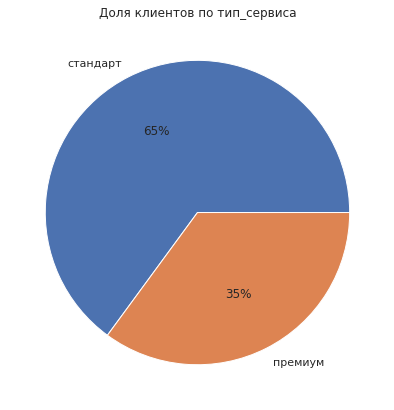

In [79]:
cat_pie(market_result_copy[market_result_copy['сегмент'] == 'исследуемый сегмент'], 'тип_сервиса')

Клиентов с премиумной подпиской больше чем в таких клиентов в общем до фильтрации (шаг 3, 29% с премиумной подпиской).

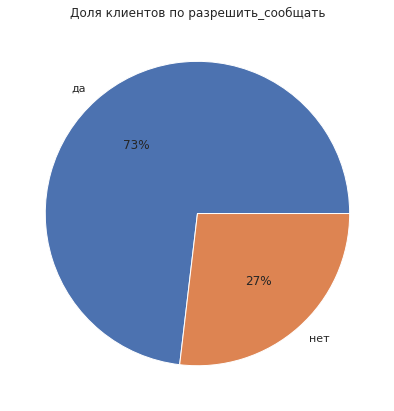

In [80]:
cat_pie(market_result_copy[market_result_copy['сегмент'] == 'исследуемый сегмент'], 'разрешить_сообщать')

Соотношение клиентов с подключенной рекламой примерно одинаково 73% против 74%.

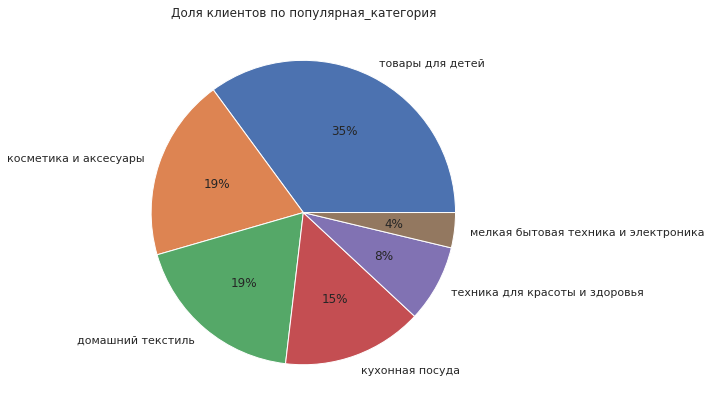

In [81]:
cat_pie(market_result_copy[market_result_copy['сегмент'] == 'исследуемый сегмент'], 'популярная_категория')

Товаров для детей покупают больше 35% против 25%, а мелкой бытовой техники покупают намного меньше всего 4% против 13%.

Построеним гистограммы.

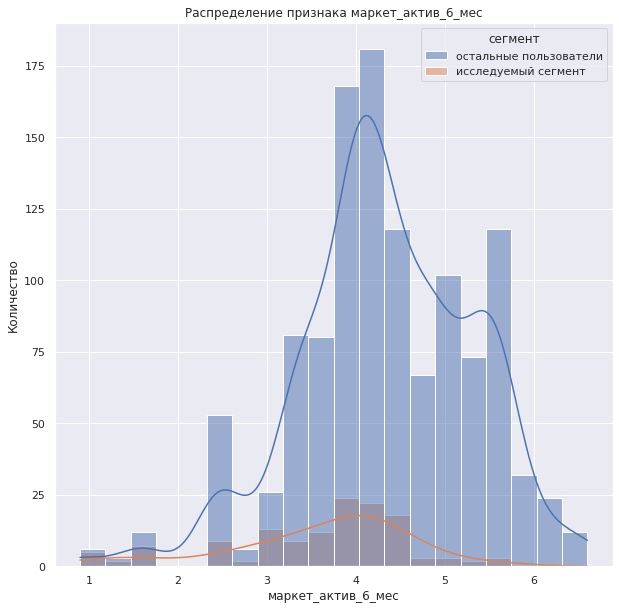

In [82]:
num_hist(market_result_copy, 'маркет_актив_6_мес', 'сегмент', 20)

Клиенты исследуемого сегмента мало получают рекламы.

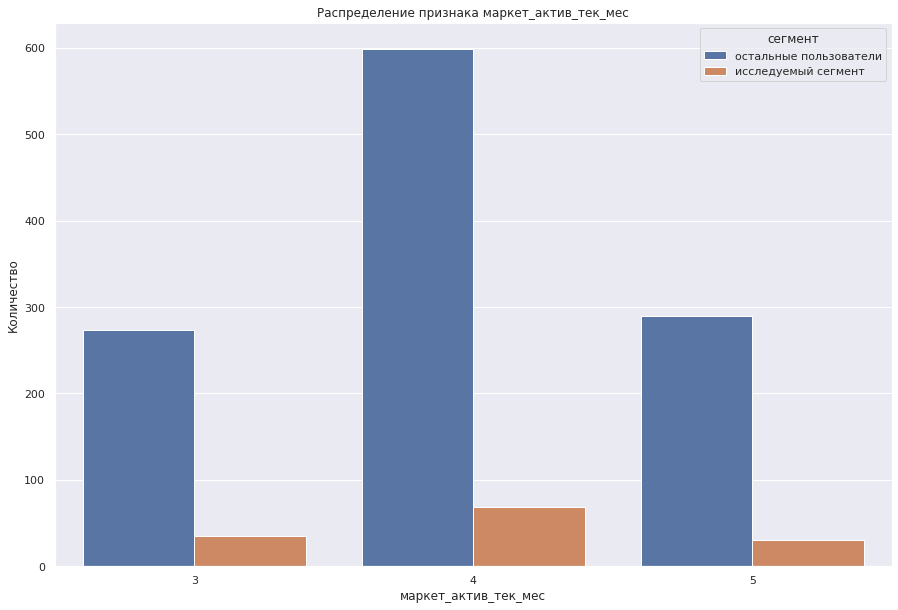

In [88]:
count_hist(market_result_copy, 'маркет_актив_тек_мес', 'сегмент')

Клиенты исследуемого сегмента мало получают рекламы.

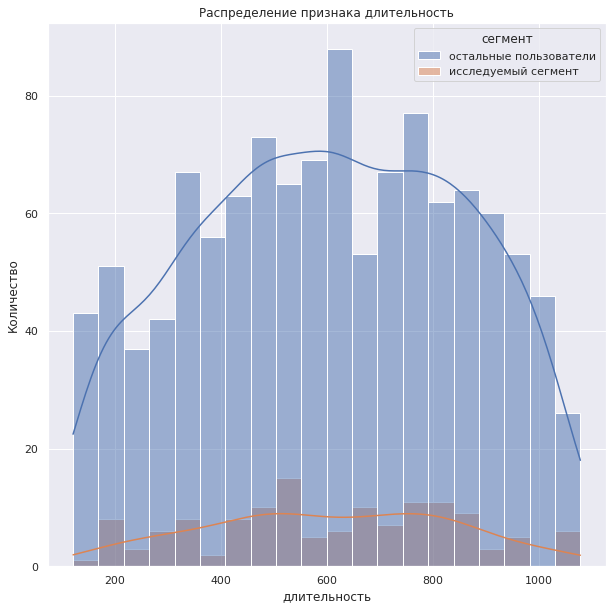

In [84]:
num_hist(market_result_copy, 'длительность', 'сегмент', 20)

Длительность в среднем сохраняется на всём протяжении времени, ярких всплесков нет как и провалов.

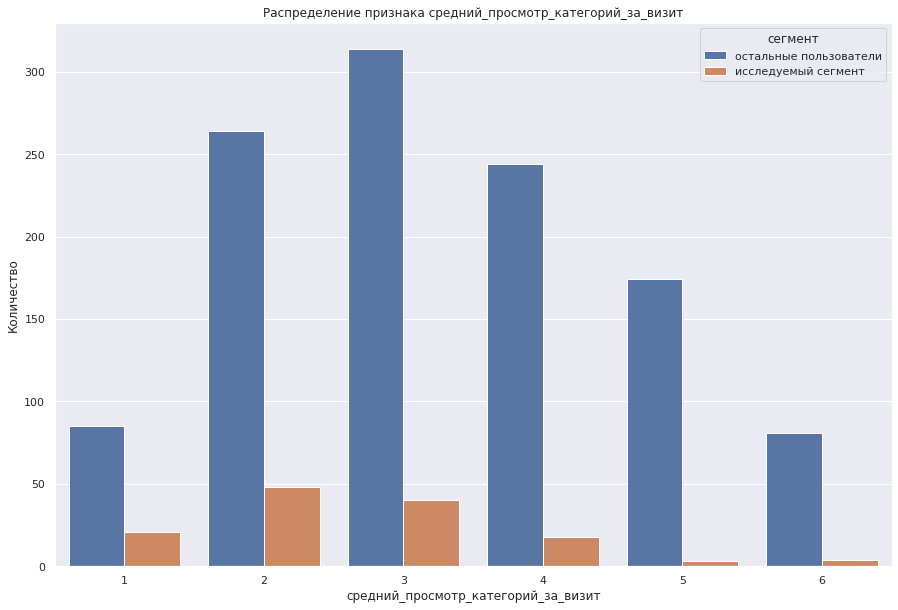

In [89]:
count_hist(market_result_copy, 'средний_просмотр_категорий_за_визит', 'сегмент')

Просматривают 2-3 категории товаров, новых товаров видимо не ищут, просматриват только в закладках.

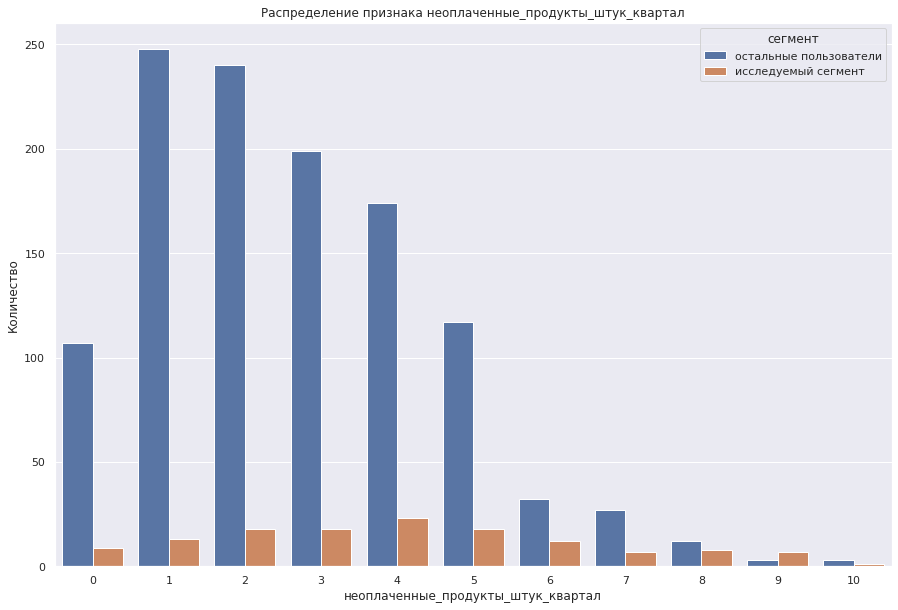

In [90]:
count_hist(market_result_copy, 'неоплаченные_продукты_штук_квартал', 'сегмент')

Картина разно направленная клиентов, чем больше покупают по акции людей сохраняют товары в корзине до последнего и не оплачивают их.

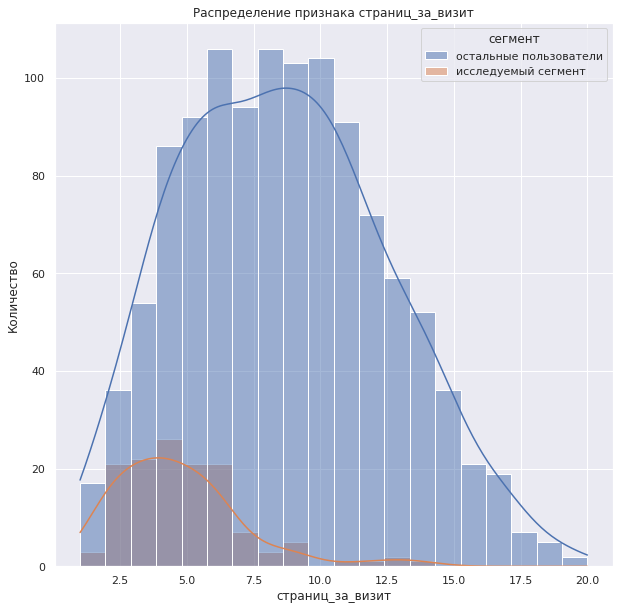

In [87]:
num_hist(market_result_copy, 'страниц_за_визит', 'сегмент', 20)

Клиенты мало просматривают страниц в магазине, ищут только нужные товары.

### Вывод

Было принято решение выделить клинтов которые покупают в основном по акции и вероятностью снижения покупательской активности т.к. за эту категорию клиетов следует поборотся и она более тругих подвержена уходу.

В ходе анализа было выявлено, что такие клиенты активно пользуются премиумной подпиской 35%. Чаще покупают товары для детей и плохо различную бытовую технику. Просматривают только нужные категории и страницы в магазине. Накапливают неоплачиваемые товары в корзине. 

Можно предположить, что такими клиентами являются клиенты с детьми и находящийся матерью в декрете. И клиенты с небольшим доходом которым нужны конкретные товары и нет средств на излишки.

Можно выдать рекомендации направить магазину больше рекламы об акциях, для повышения просмотров категорий и страниц в магазине. При возможности предлогать рассрочку в оплате товаров, для повышения лояльности клиентов, повышения товаро оборота и снижения тем самым скапливаемости товаров на складах и снижение складских расходов.

## Общий вывод

В работу поступило 3 датасета
- market_file - 13 столбцов, 1300 строк, 0 пропусков, 0 дубликатов;
- market_money - 3 столбцов, 3900 строк, 0 пропусков, 0 дубликатов;
- market_time - 3 столбцов, 2600 строк, 0 пропусков, 0 дубликатов;
- money - 2 столбцов, 1300 строк, 0 пропусков, 0 дубликатов.

В market_file и market_time отредактированы название столбцов. В money произведено разделение столбцов и проведена замена тип столбца "Прибыль" на float64.

Во всех четырёх датасетах название столбцов соотвествуют описанию.

Было выполнено:
- market_file - Исправлена опечатка в обозначении данных на "стандарт". В столбце "Длительность" данные без выбросов, в столбцах "Акционные_покупки" и "Маркет_актив_6_мес" имеются выбросы, принято решение их не удалять т.к. их достаточно много их влияние оценим на следующем шаге.
- market_money - Были удаленны два значения 106862.2 - это явный выброс и 0 - это значение удаленно по условиям исследования. Так же большое колличество выбросов которые не будут удаленны.
- market_time - Исправленна опечатка в данных на 'предыдущий_месяц'. Данные без выбросов.
- money - Значения прибыли имеют выбросы их удалять не будем.

Обобщая информацию по всем 4 датафреймам можно увидеть, что даже при снижении маркетинговой активности время пользователей в магазине не изменилось, выручка при этом расла последнии 3 месяца. 

Пользователи со сниженной покупательской активностью просматривают страниц и категорий товаров одинаково, что даёт нам понять, что они ищут товары только по акции. Они же получают всех больше рекламных уведомлений от магазина.

Пользователи с прежней активностью просматривают большое количество страниц в магазине и различные категории, и отправляют товары в корзину и оплачивают их когда в корзине становится 6 и более товаров.

По итогу 1296 клиентов сохраняло свою активность на протяжении не менее трёх месяцев.

Итоговая таблица market_result состоящая из market_file, market_money, market_time:
- 18 столбцов,
- 1296 записей,
- пропуски отсуствуют,
- дубликаты отсуствуют.

О мультиколлинеарности можно говорить если значение корреляции выше 0.9. Такой корреляции для целевого признака, покупательская активность, нет.

Проведён дополнительный анализ по VIF метрике. По её условиям о мультиколлинеарности можно говорить при значении метрики выше 5, не один параметр не отвечает данному условию.

Поэтому можно сделать вывод об отсуствии мультиколлиарности.

Способ для поиска модели и гиперпараметров был выбран RandomizedSearchCV потому, что перед нами стоит задача найти лучшую модель идля экономии времени был выбран этот способ при следующих параметрах:
- cv=5 стандарное количество раз тестирования модели,
- scoring - стратегия оценки производительности модели была выбрана 'roc_auc' т.к. эта метрика работает при оценки сразу 4 моделей и отсуствует необходимость выберать определённые пороги отсечения и учитывает возможность дисбаланса классов.

В результате работы поплайна были обработаны 4 модели:  KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и SVC(). Лучшей стала с гиперпараметрами SVC:
- С - параметр регуляризации = 1.668,
- kernel - ядро полиномиальное,
- degree - степень полимиального ядра = 2,
- random_state=100)

Метрики:
- метрика по кросс валидационной выборке: 0.897
- ROC-AUC на тестовых данных: 0.906 
- F1 на тестовых данных: 0.879

Модель выдаёт довольно хорошие метрики, что даёт нам уверенность в её работоспособности.

Для модели важны признаки (интрепритация по beeswarm):
- Самыми важными признаками для сохранения покупательской активности просмотр страниц_за_визит, минут_текущий_месяц, минут_предыдущий_месяц, средний_просмотр_категорий_за_визит, маркет_актив_6_мес;
- Признаки неоплаченные_продукты_штук_квартал, разрешить_сообщать_нет, ошибка_сервиса, маркет_актив_тек_мес отрицательно влияют на сохранение покупательской активности, но их значение настолько невелико, что можно предположить, что нам необходимо искать другую причину влияющую на снижение покупательской активности.

Было принято решение выделить клинтов которые покупают в основном по акции и вероятностью снижения покупательской активности т.к. за эту категорию клиетов следует поборотся и она более тругих подвержена уходу.

В ходе анализа было выявлено, что такие клиенты активно пользуются премиумной подпиской 35%. Чаще покупают товары для детей и плохо различную бытовую технику. Просматривают только нужные категории и страницы в магазине. Накапливают неоплачиваемые товары в корзине. 

Можно предположить, что такими клиентами являются клиенты с детьми и находящийся матерью в декрете. И клиенты с небольшим доходом которым нужны конкретные товары и нет средств на излишки.

Можно выдать рекомендации направить магазину больше рекламы об акциях, для повышения просмотров категорий и страниц в магазине. При возможности предлогать рассрочку в оплате товаров, для повышения лояльности клиентов, повышения товаро оборота и снижения тем самым скапливаемости товаров на складах и снижение складских расходов.